<a href="https://colab.research.google.com/github/tomsoch/TransferLearning/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x 
!ls -l 
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

TensorFlow 1.x selected.
total 42868
-rwxr-xr-x 1 root root 30053267 May  4  2021 ngrok
-rw-r--r-- 1 root root 13832437 Mar 15 20:58 ngrok-stable-linux-amd64.zip
drwxr-xr-x 1 root root     4096 Mar  9 14:48 sample_data
--2022-03-15 20:59:20--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  30.5MB/s    in 0.4s    

2022-03-15 20:59:21 (30.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [2]:
LOG_DIR = '/root/models/trained'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [3]:
import time
time.sleep(0.5)
!curl -s http://localhost:4040/api/tunnels | python3 -c \
   "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"  

https://cfc3-34-67-224-184.ngrok.io


In [4]:
%cd 
!git clone https://github.com/tensorflow/models.git

/root
fatal: destination path 'models' already exists and is not an empty directory.


In [5]:
%cd /root/models/research/ 
!protoc object_detection/protos/*.proto --python_out=.
!python /root/models/research/slim/setup.py build

/root/models/research
running build
running build_py
copying object_detection/protos/region_similarity_calculator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/input_reader_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/square_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/grid_anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/optimizer_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/hyperparams_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/keypoint_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/ssd_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/pipelin

In [6]:
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

In [7]:
!pip install tf_slim
!pip install numpy==1.19.5

In [8]:
!python object_detection/builders/model_builder_test.py #testing if builder works

Using TensorFlow backend.


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
!pwd
!cp -r /content/gdrive/MyDrive/TransferLearning/cube /root/models/TransferLearning 
%cd /root/models/
!pwd


Mounted at /content/gdrive
/root/models/research
/root/models
/root/models


In [10]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path): 
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():

	image_path = os.path.join(os.getcwd(), 'TransferLearning/images/train')
	xml_df = xml_to_csv(image_path)
	xml_df.to_csv('TransferLearning/data/train_labels.csv', index=None)

	image_path = os.path.join(os.getcwd(), 'TransferLearning/images/test')
	xml_df = xml_to_csv(image_path)
	xml_df.to_csv('TransferLearning/data/test_labels.csv',index=None)

main()

In [11]:
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

%cd /root/models/TransferLearning/tfrecord/
!python generate_tfrecord.py --csv_input=/root/models/TransferLearning/data/train_labels.csv  --output_path=train.record --image_dir=/root/models/TransferLearning/images/train
!python generate_tfrecord.py --csv_input=/root/models/TransferLearning/data/test_labels.csv  --output_path=test.record --image_dir=/root/models/TransferLearning/images/test

/root/models/research
/root/models/TransferLearning/tfrecord


W0315 21:00:38.781266 140074834110336 module_wrapper.py:139] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0315 21:00:38.827940 140074834110336 module_wrapper.py:139] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /root/models/TransferLearning/tfrecord/train.record


W0315 21:00:41.355629 140040439719808 module_wrapper.py:139] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0315 21:00:41.363643 140040439719808 module_wrapper.py:139] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /root/models/TransferLearning/tfrecord/test.record


In [12]:
Selected_model = 'ssd_mobilenet_v1_coco' #@param ["ssdlite_mobilenet_v2_coco", "ssd_mobilenet_v1_coco", "3rd option"]
if Selected_model=='ssdlite_mobilenet_v2_coco':
  model_name=Selected_model+'_2018_05_09'
  model_fullname=model_name+'.tar.gz'
elif Selected_model=='ssd_mobilenet_v1_coco':
  model_name=Selected_model+'_2017_11_17'
  model_fullname=model_name+'.tar.gz'
pbtxt_path = '/root/models/TransferLearning/data/object-detection.pbtxt'
!pwd

/root/models/TransferLearning/tfrecord


In [13]:
print("Selected model: ", Selected_model)
print("Model name: ", model_name)
print("Model fullname: ", model_fullname)

Selected model:  ssd_mobilenet_v1_coco
Model name:  ssd_mobilenet_v1_coco_2017_11_17
Model fullname:  ssd_mobilenet_v1_coco_2017_11_17.tar.gz


In [14]:
%cd ~/models

import os
import shutil
import glob
import urllib
import tarfile
from requests import get


MODEL2 = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL = 'ssdlite_mobilenet_v2_coco_2018_05_09'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
destination_dir = 'pretrained_model'

if not (os.path.exists(model_fullname)):
  with open(model_fullname, "wb") as file:
    response = get(DOWNLOAD_BASE + model_fullname)
    file.write(response.content)
!pwd
tar = tarfile.open(model_fullname)
tar.extractall()
tar.close()

os.remove(model_fullname)
if (os.path.exists(destination_dir)):
  shutil.rmtree(destination_dir)
os.rename(model_name, destination_dir)

/root/models
/root/models


In [15]:
shutil.move("/root/models/research/object_detection/samples/configs/"+Selected_model+".config", "/root/models")

'/root/models/ssd_mobilenet_v1_coco.config'

In [16]:
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

import tensorflow as tf
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

pipeline = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          
config_path = '/root/models/'+Selected_model+'.config'
with tf.gfile.GFile( config_path, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline)

pipeline.train_input_reader.tf_record_input_reader.input_path[:] = ['/root/models/TransferLearning/tfrecord/train.record'] 
pipeline.train_input_reader.label_map_path = pbtxt_path
pipeline.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['/root/models/TransferLearning/tfrecord/test.record'] 
pipeline.eval_input_reader[0].label_map_path = pbtxt_path
pipeline.train_config.fine_tune_checkpoint = '/root/models/pretrained_model/model.ckpt'
pipeline.train_config.num_steps = 500 # Number of training steps
#pipeline.train_config.batch_size = 16
pipeline.model.ssd.num_classes = 1 # Number of classes to detect
# pipeline.eval_config.num_examples = 126 # Number of test images

config_text = text_format.MessageToString(pipeline)                                                                                                                                                                                                        
with tf.gfile.Open( config_path, "wb") as f:                                                                                                                                                                                                                       
    f.write(config_text)

/root/models/research


In [17]:
# models directory
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'
config_path='/root/models/'+Selected_model+'.config'
print(config_path)
# TRAINING
!python /root/models/research/object_detection/legacy/train.py \
    --logtostderr \
    --train_dir=/root/models/trained \
    --pipeline_config_path=$config_path

/root/models/research
/root/models/ssd_mobilenet_v1_coco.config
Using TensorFlow backend.
Instructions for updating:
Use object_detection/model_main.py.
W0315 21:01:04.676218 140425349941120 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/absl/app.py:258: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.
Instructions for updating:
Please switch to tf.train.create_global_step
W0315 21:01:04.692667 140425349941120 deprecation.py:323] From /root/models/research/object_detection/legacy/trainer.py:265: create_global_step (from tf_slim.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.create_global_step
INFO:tensorflow:Reading unweighted datasets: ['/root/models/TransferLearning/tfrecord/train.record']
I0315 21:01:04.711365 140425349941120 dataset_builder.py:163] Reading unweighted datasets: ['/root/models/TransferLe

In [19]:
%cd /root/models/research
!protoc object_detection/protos/*.proto --python_out=.
import os 
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'
!python /root/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=$config_path \
    --output_directory=/root/models/fine_tuned_model \
    --trained_checkpoint_prefix=/root/models/trained/model.ckpt-500 
# in above line "model.ckpt-2000" - change number for the last checkpoint to load, last checkpoint equals number of steps

/root/models/research
Using TensorFlow backend.
Instructions for updating:
Please use `layer.__call__` method instead.
W0315 21:07:56.834866 140469507516288 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0315 21:07:58.600775 140469507516288 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0315 21:07:58.648700 140469507516288 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0315 21:07:58.694632 140469507516288 convolutional_box_predictor.py:156] depth of additional conv before box predictor:

In [20]:
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

In [22]:

PATH_TO_CKPT = '/root/models/fine_tuned_model' + '/frozen_inference_graph.pb'

PATH_TO_LABELS = pbtxt_path

NUM_CLASSES = 1

In [23]:
print(PATH_TO_CKPT)

/root/models/fine_tuned_model/frozen_inference_graph.pb


In [24]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [25]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [26]:
print(category_index)

{1: {'id': 1, 'name': 'cube'}}


In [27]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [28]:
import glob
TEST_IMAGE_PATHS2 = (glob.glob("/root/models/TransferLearning/images/test/*.jpg")) #change to jpg or png


IMAGE_SIZE = (12, 8)

In [29]:
print(TEST_IMAGE_PATHS2)

['/root/models/TransferLearning/images/test/7.jpg', '/root/models/TransferLearning/images/test/182.jpg', '/root/models/TransferLearning/images/test/150.jpg', '/root/models/TransferLearning/images/test/4.jpg', '/root/models/TransferLearning/images/test/129.jpg', '/root/models/TransferLearning/images/test/8.jpg', '/root/models/TransferLearning/images/test/72.jpg', '/root/models/TransferLearning/images/test/77.jpg', '/root/models/TransferLearning/images/test/3.jpg', '/root/models/TransferLearning/images/test/6.jpg', '/root/models/TransferLearning/images/test/199.jpg', '/root/models/TransferLearning/images/test/172.jpg', '/root/models/TransferLearning/images/test/109.jpg', '/root/models/TransferLearning/images/test/161.jpg', '/root/models/TransferLearning/images/test/2.jpg', '/root/models/TransferLearning/images/test/9.jpg', '/root/models/TransferLearning/images/test/5.jpg', '/root/models/TransferLearning/images/test/1.jpg']


In [30]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

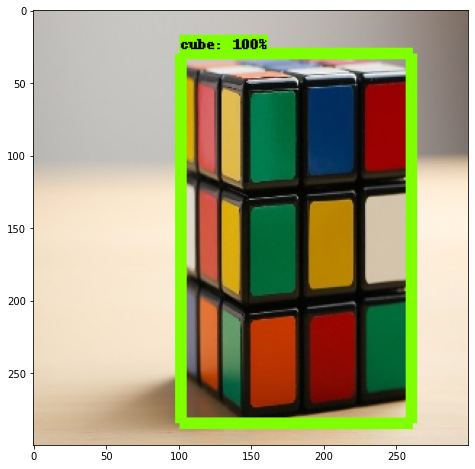

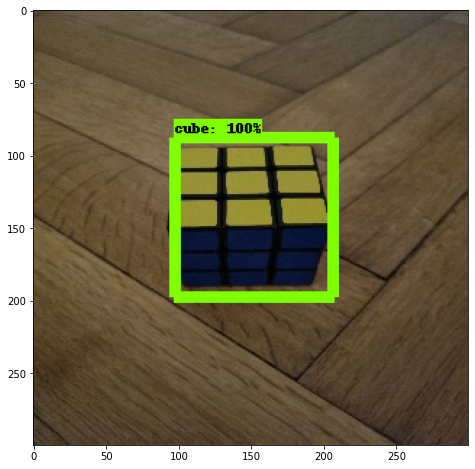

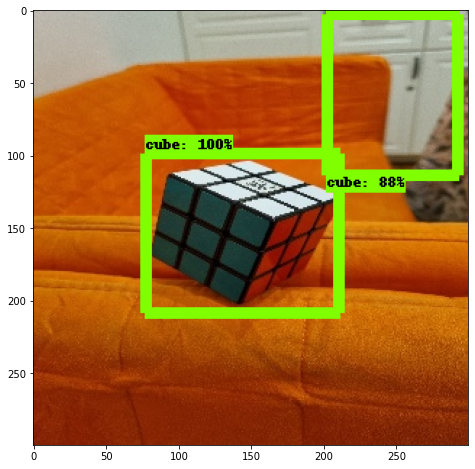

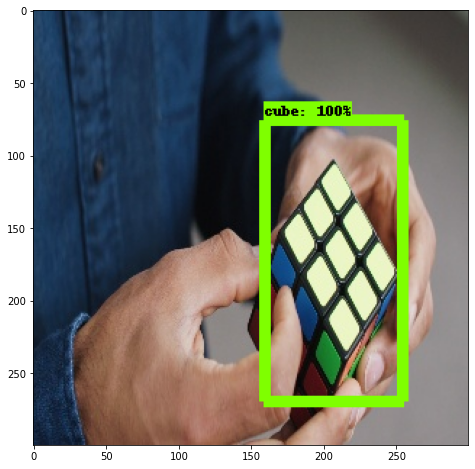

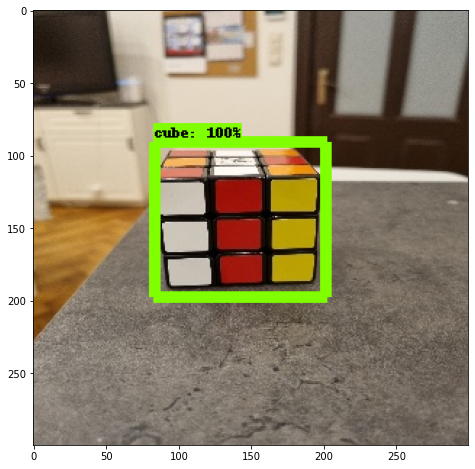

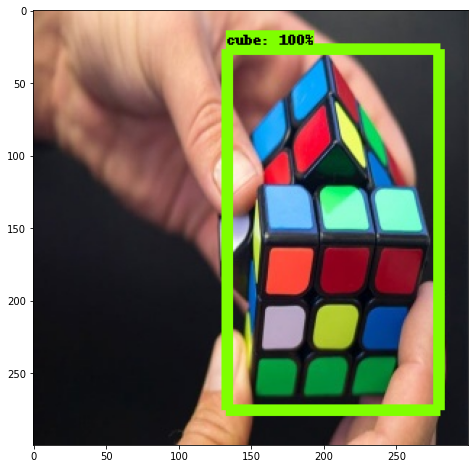

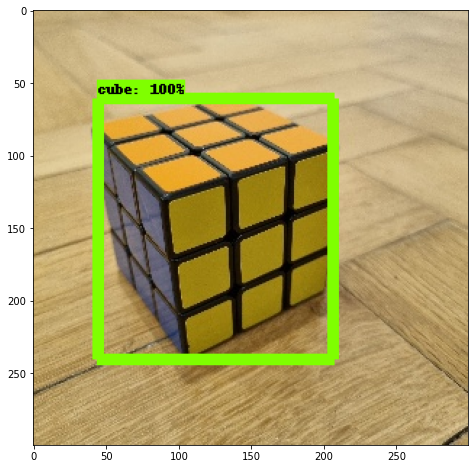

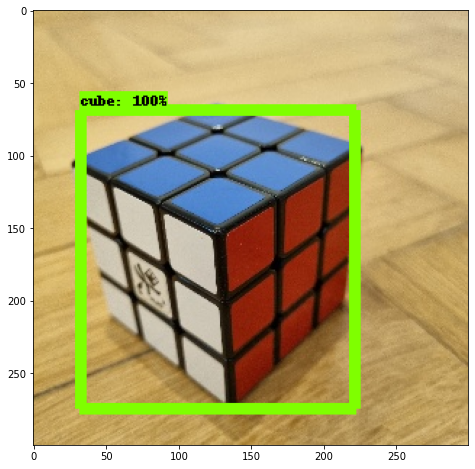

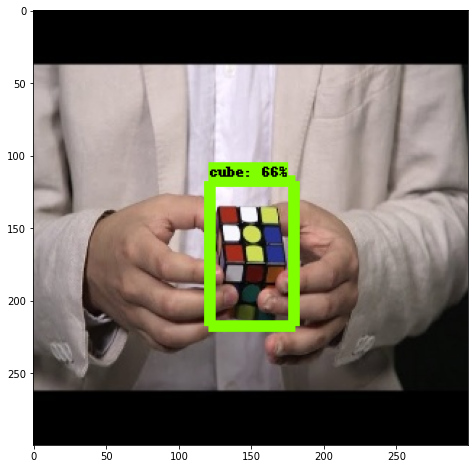

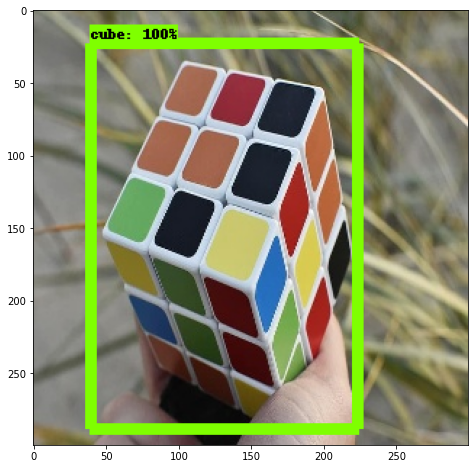

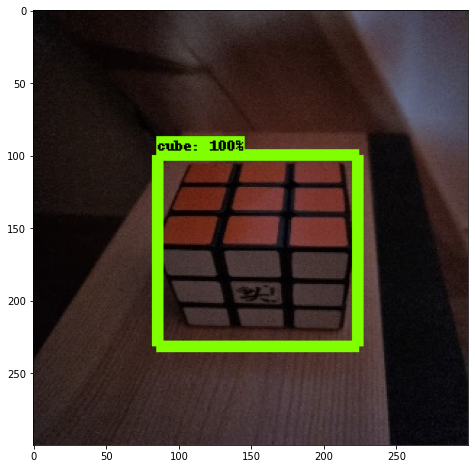

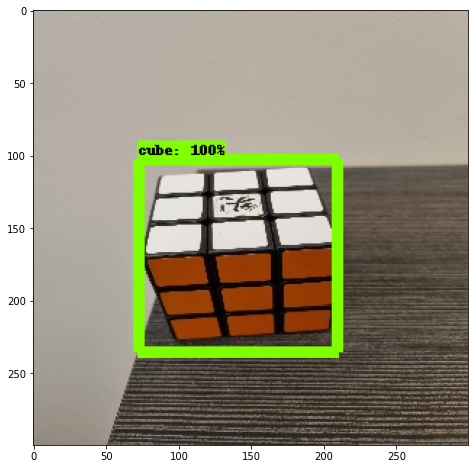

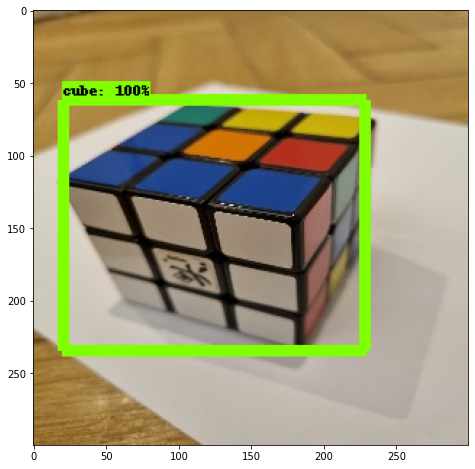

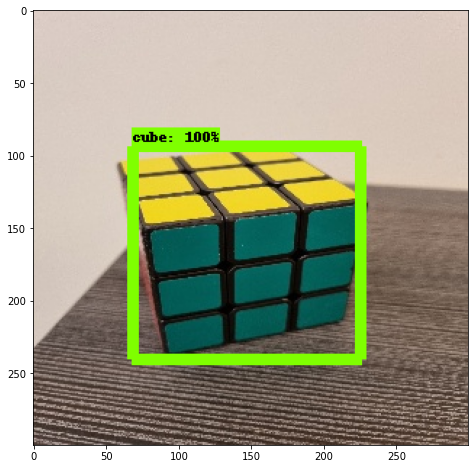

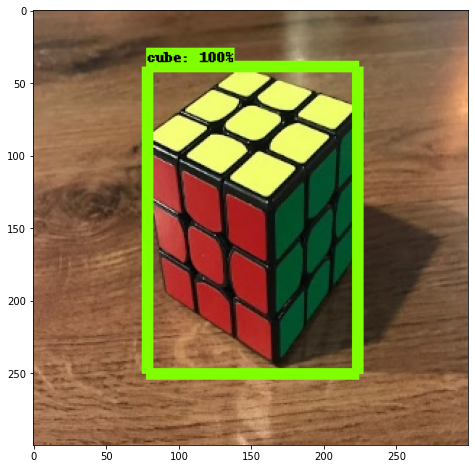

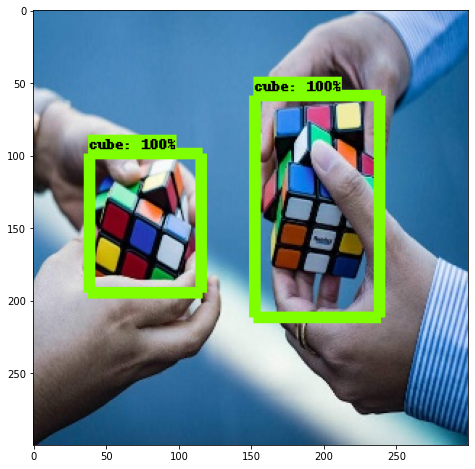

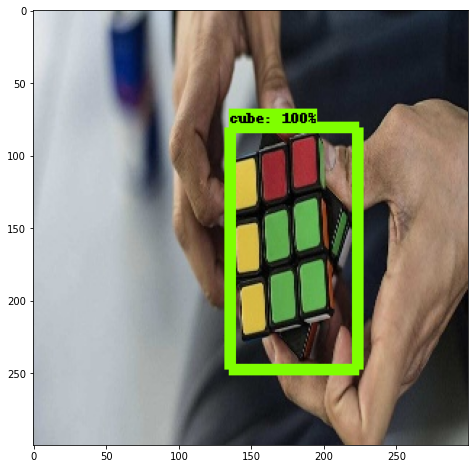

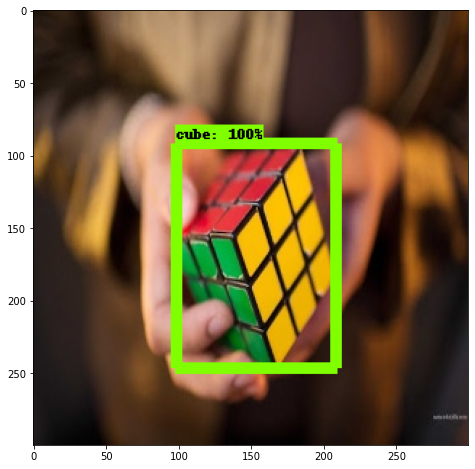

In [31]:
import cv2
for image_path in TEST_IMAGE_PATHS2:
  image = Image.open(image_path)
  image_np = image_np = cv2.imread(image_path,1)
  image_np = image_np[...,::-1]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)